# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print("We're using TF", tf.__version__)

Instructions for updating:
non-resource variables are not supported in the long term
We're using TF 2.8.0


In [2]:
import sys
sys.path.append("../..")

In [3]:
!

# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [4]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

X shape is (60000, 28, 28), y shape is (60000,)
y is 5


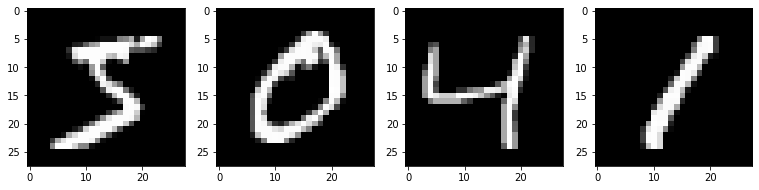

In [5]:
print('X shape is {}, y shape is {}'.format(train_X.shape, train_y.shape))
fig, ax = plt.subplots(1, 4, figsize=(13,5))
ax[0].imshow(train_X[0,:], cmap='gray')
ax[1].imshow(train_X[1,:], cmap='gray')
ax[2].imshow(train_X[2,:], cmap='gray')
ax[3].imshow(train_X[3,:], cmap='gray')
print('y is %d' % train_y[0])


# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [6]:
X_train_flat = train_X.reshape((train_X.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = test_X.reshape((test_X.shape[0], -1))
print(X_val_flat.shape)

(60000, 784)
(10000, 784)


In [7]:
X_train_flat = X_train_flat/255 - 0.5
X_val_flat = X_val_flat/255 - 0.5

In [8]:

y_train_oh = tf.keras.utils.to_categorical(train_y)
y_val_oh = tf.keras.utils.to_categorical(test_y)

print(y_train_oh.shape)
print(y_train_oh[:3], train_y[:3])

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [9]:
# run this again if you remake your graph
tf.reset_default_graph()

In [10]:
# Model parameters: W and b
W = tf.get_variable('Lin_W', shape=(784,10), dtype=tf.float32)
b = tf.get_variable('Lin_b', shape=(10,))

In [11]:
# Placeholders for the input data
input_X = tf.placeholder('float32', shape=(None,784))
input_y = tf.placeholder('int32', shape=(None, 10))

In [12]:
# Compute predictions
logits = (b + input_X @ W)# logits for input_X, resulting shape should be [input_X.shape[0], 10]
probas = tf.nn.softmax(logits)# apply tf.nn.softmax to logits
classes = tf.argmax(probas, axis=1)# apply tf.argmax to find a class index with highest probability

# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=input_y, logits=logits))# cross-entropy loss

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer().minimize(loss)# optimizer step that minimizes the loss

<IPython.core.display.Javascript object>


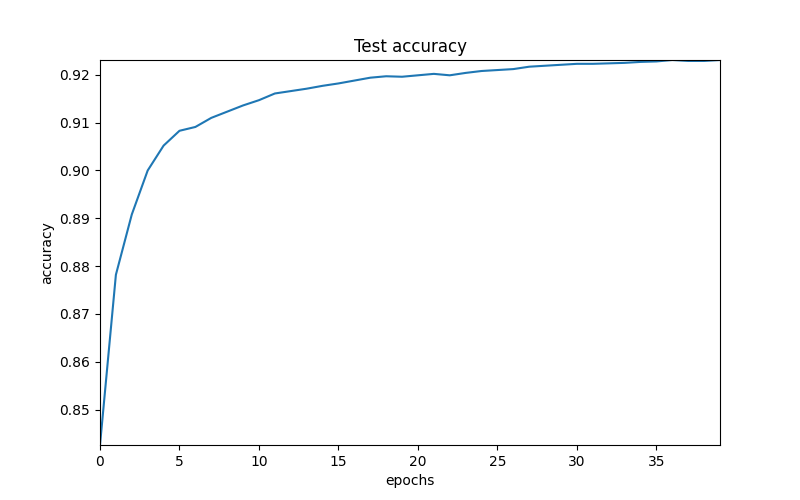

C:\Users\Сено\AppData\Local\Temp\ipykernel_12864\1363863427.py:41: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(min(x), max(x))
C:\Users\Сено\AppData\Local\Temp\ipykernel_12864\1363863427.py:42: UserWarning: Attempting to set identical bottom == top == 0.8426 results in singular transformations; automatically expanding.
  ax.set_ylim(min(y), max(y))


In [13]:
# tf.reset_default_graph()
%matplotlib notebook

s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40


x = []
y = []
# to run GUI event loop
plt.ion()
 
# here we are creating sub plots
figure, ax = plt.subplots(figsize=(8, 5))
line1, = ax.plot(x, y)
ax.set_title('Test accuracy')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')


for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)
    
    train_loss = np.mean(batch_losses)
    test_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(train_y, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    test_accuracy = accuracy_score(test_y, s.run(classes, {input_X: X_val_flat})) 
     # creating new Y values
    x.append(epoch)
    y.append(test_accuracy)
    line1.set_xdata(x)
    line1.set_ydata(y)
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(min(y), max(y))
    figure.canvas.draw()
    figure.canvas.flush_events()    
    
s.close()

# MLP with hidden layers

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convenient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (remember that we need it for a hidden layer!).

Now define the MLP with 2 hidden layers and restart training with the cell above.

You're aiming for ~0.97 validation accuracy here.

In [14]:
tf.reset_default_graph()

In [15]:
# Model parameters: W and b
W = tf.get_variable('Lin_W', shape=(784,10), dtype=tf.float32)
b = tf.get_variable('Lin_b', shape=(10,))

In [16]:
# Placeholders for the input data
input_X = tf.placeholder('float32', shape=(None,784))
input_y = tf.placeholder('int32', shape=(None, 10))

In [28]:
# write the code here to get a new `step` operation and then run the cell with training loop above.
# name your variables in the same way (e.g. logits, probas, classes, etc) for safety.

hide1 = tf.layers.dense(input_X, 784, activation=tf.nn.relu)
hide2 = tf.layers.dense(hide1, 600, activation=tf.nn.relu)
hide3 = tf.layers.dense(hide2, 500, activation=tf.nn.relu)
hide4 = tf.layers.dense(hide3, 400, activation=tf.nn.relu)
logits2 = tf.layers.dense(hide4, 10, activation=None)
probas = tf.nn.softmax(logits2)
classes = tf.argmax(probas, axis=1)
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=input_y, logits=logits2))

step = tf.train.AdamOptimizer().minimize(loss)

C:\Users\Сено\AppData\Local\Temp\ipykernel_12864\3123203240.py:4: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  hide1 = tf.layers.dense(input_X, 784, activation=tf.nn.relu)
c:\users\сено\python 64bit\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\Users\Сено\AppData\Local\Temp\ipykernel_12864\3123203240.py:5: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  hide2 = tf.layers.dense(hide1, 600, activation=tf.nn.relu)
C:\Users\Сено\AppData\Local\Temp\ipykernel_12864\3123203240.py:6: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  hide3 = tf.layers.dense(hide2, 500, activation=tf.

c:\users\сено\python 64bit\lib\site-packages\tensorflow\python\client\session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


<IPython.core.display.Javascript object>


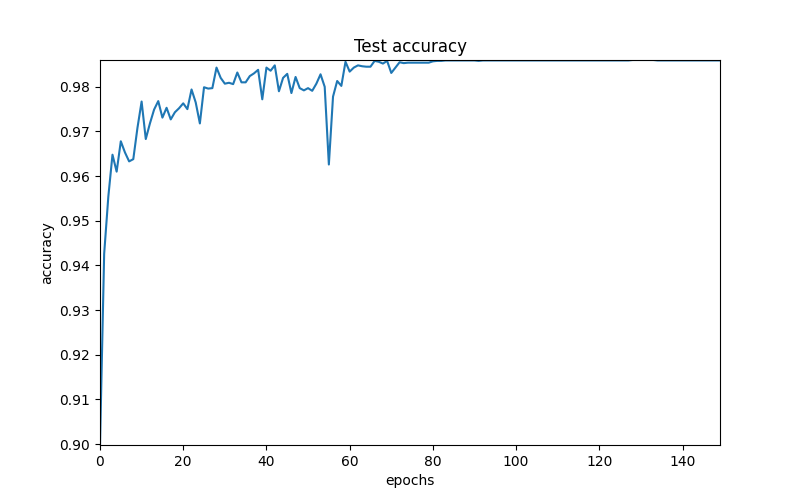

C:\Users\Сено\AppData\Local\Temp\ipykernel_12864\892282177.py:40: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(min(x), max(x))
C:\Users\Сено\AppData\Local\Temp\ipykernel_12864\892282177.py:41: UserWarning: Attempting to set identical bottom == top == 0.8998 results in singular transformations; automatically expanding.
  ax.set_ylim(min(y), max(y))


In [29]:
%matplotlib notebook

s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

BATCH_SIZE = 2048
EPOCHS = 150


x = []
y = []
# to run GUI event loop
plt.ion()
 
# here we are creating sub plots
figure, ax = plt.subplots(figsize=(8, 5))
line1, = ax.plot(x, y)
ax.set_title('Test accuracy')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')


for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
#         batch_losses.append(batch_loss)
    
#     train_loss = np.mean(batch_losses)
#     test_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
#     train_accuracy = accuracy_score(train_y, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    test_accuracy = accuracy_score(test_y, s.run(classes, {input_X: X_val_flat})) 
     # creating new Y values
    x.append(epoch)
    y.append(test_accuracy)
    line1.set_xdata(x)
    line1.set_ydata(y)
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(min(y), max(y))
    figure.canvas.draw()
    figure.canvas.flush_events()    
    
s.close()


In [ ]:
# 986